In [1]:
!pip install -Uq bayeux-ml

In [1]:
import functools

import arviz as az
import bayeux as bx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro


dist = numpyro.distributions

# Using bayeux with numpyro

[More on NumPyro here](https://num.pyro.ai/en/latest/index.html#)

We implement a common hierarchical model of the eight schools dataset (Rubin 1981¹), whose details can be seen on the [Stan documentation](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html), [PyMC documentation](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html), [TFP documentation](https://www.tensorflow.org/probability/examples/Eight_Schools), [numpyro documentation](https://num.pyro.ai/en/stable/getting_started.html#a-simple-example-8-schools), among others.

Note that the sections after "Defining bayeux model" are the same no matter how the model was defined.

¹ _Rubin, Donald B. 1981. “Estimation in Parallel Randomized Experiments.” Journal of Educational and Behavioral Statistics 6 (4): 377–401._

In [2]:
num_schools = 8
treatment_effects = np.array([28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)
treatment_stddevs = np.array([15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)

In [3]:
def numpyro_model():
  avg_effect = numpyro.sample('avg_effect', dist.Normal(0., 10.))
  avg_stddev = numpyro.sample('avg_stddev', dist.HalfNormal(10.))
  with numpyro.plate('J', 8):
    school_effects = numpyro.sample('school_effects', dist.Normal(0., 1.))
    numpyro.sample('observed',
                   dist.Normal(avg_effect[..., None] + avg_stddev[..., None] * school_effects,
                               treatment_stddevs),
                   obs=treatment_effects)

In [4]:
def log_density(*args, **kwargs):
  # This clause is only required because the tfp vi routine tries to
  # pass dictionaries as keyword arguments, so this allows either
  # log_density(params) or log_density(**params)
  if args:
    x = args[0]
  else:
    x = kwargs
  return numpyro.infer.util.log_density(numpyro_model, (), {}, x)[0]

test_point = numpyro.infer.Predictive(
    numpyro_model, num_samples=1)(jax.random.PRNGKey(0))
test_point = {k: v[0] for k, v in test_point.items() if k != 'observed'}

def transform_fn(x):
  return numpyro.infer.util.constrain_fn(numpyro_model, (), {}, x)

bx_model = bx.Model(
    log_density=log_density,
    test_point=test_point,
    transform_fn=transform_fn
)

In [5]:
idata = bx_model.mcmc.blackjax_nuts(seed=jax.random.PRNGKey(0))

az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg_effect,6.385,4.187,-1.606,13.963,0.077,0.054,2973.0,2617.0,1.0
avg_stddev,4.766,3.674,0.004,11.351,0.074,0.052,2103.0,1898.0,1.0
school_effects[0],0.380,0.968,-1.318,2.263,0.016,0.015,3684.0,2572.0,1.0
school_effects[1],0.062,0.910,-1.719,1.715,0.014,0.014,4193.0,3151.0,1.0
school_effects[2],-0.135,0.965,-1.952,1.634,0.015,0.015,4220.0,2863.0,1.0
school_effects[3],0.023,0.925,-1.785,1.728,0.014,0.016,4238.0,3029.0,1.0
school_effects[4],-0.257,0.928,-1.921,1.550,0.015,0.014,3756.0,2540.0,1.0
school_effects[5],-0.150,0.925,-1.857,1.642,0.014,0.015,4486.0,3096.0,1.0
school_effects[6],0.370,0.933,-1.370,2.092,0.016,0.014,3479.0,2830.0,1.0
school_effects[7],0.073,0.961,-1.687,1.909,0.015,0.015,4111.0,2881.0,1.0


{'avg_effect': Array([6.1705155, 6.1705127, 6.170513 , 6.170519 , 6.170515 , 6.170517 ,
        6.170514 , 6.1705165], dtype=float32),
 'avg_stddev': Array([10.625165, 10.625165, 10.625167, 10.625208, 10.625165, 10.625165,
        10.625165, 10.625162], dtype=float32),
 'school_effects': Array([[ 0.6864336 ,  0.0913063 , -0.26413608,  0.0376812 , -0.39293465,
         -0.23488225,  0.5903883 ,  0.14177173],
        [ 0.6864337 ,  0.09130644, -0.264136  ,  0.03768136, -0.39293548,
         -0.23488212,  0.59038854,  0.1417718 ],
        [ 0.6864336 ,  0.09130643, -0.26413602,  0.03768134, -0.39293548,
         -0.23488215,  0.5903885 ,  0.14177181],
        [ 0.68643135,  0.09130613, -0.26380217,  0.03768104, -0.3929361 ,
         -0.23488227,  0.5903887 ,  0.14177082],
        [ 0.68643355,  0.09130631, -0.26413605,  0.03768123, -0.3929356 ,
         -0.23488222,  0.59038836,  0.14177173],
        [ 0.68643355,  0.09130622, -0.26413608,  0.03768112, -0.39293572,
         -0.23488232,  

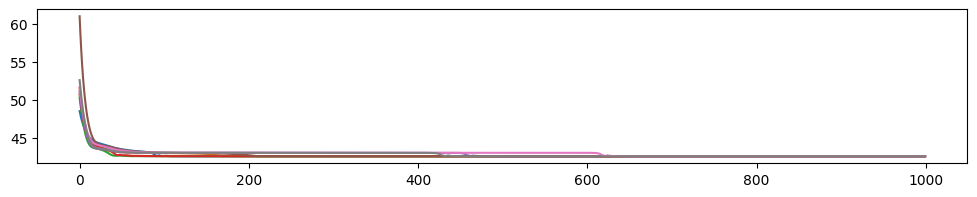

In [6]:
opt_results = bx_model.optimize.optax_adam(seed=jax.random.PRNGKey(0))


fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(opt_results.loss.T)
opt_results.params

{'avg_effect': Array(6.462982, dtype=float32),
 'avg_stddev': Array(3.9471087, dtype=float32),
 'school_effects': Array([ 0.36255652,  0.05804498, -0.17273399, -0.0188475 , -0.21912186,
        -0.16507226,  0.30446446,  0.06365628], dtype=float32)}

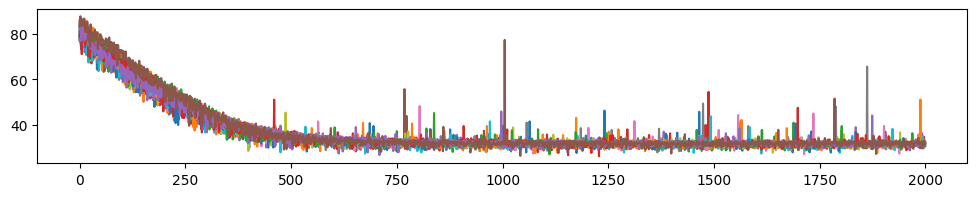

In [7]:
surrogate_posterior, losses = bx_model.vi.tfp_factored_surrogate_posterior(
    seed=jax.random.PRNGKey(0))


fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(losses.T)

draws = surrogate_posterior.sample(100, seed=jax.random.PRNGKey(1))
jax.tree_map(lambda x: jnp.mean(x, axis=(0, 1)), draws)